<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [ ]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [ ]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import pad_sequences, to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [ ]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [ ]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [ ]:
print(df.shape)

(23486, 10)


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [ ]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


Observar como está distribuido el dataset respecto a la columna Rating,
es decir, observar que tan balanceado se encuentra respecot a cada clase

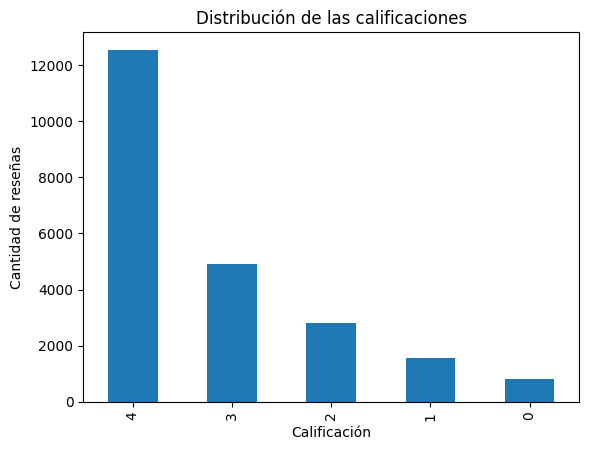

In [ ]:
df_reviews.Rating.value_counts().plot(kind='bar', title='Distribución de las calificaciones')
plt.xlabel('Calificación')
plt.ylabel('Cantidad de reseñas')
plt.show()

Mapeo los reviews para poder tomar una muestra balanceada

In [ ]:
def transform_rating(df):
  df['Rating'] = df['Rating'].map({0: 0, 1: 0, 2: 0, 3: 1, 4: 2})
  return df

In [ ]:
df_reviews_mapped = transform_rating(df_reviews)
df_reviews_mapped

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,2
2,I had such high hopes for this dress and reall...,0
3,"I love, love, love this jumpsuit. it's fun, fl...",2
4,This shirt is very flattering to all due to th...,2
...,...,...
23481,I was very happy to snag this dress at such a ...,2
23482,"It reminds me of maternity clothes. soft, stre...",0
23483,"This fit well, but the top was very see throug...",0
23484,I bought this dress for a wedding i have this ...,0


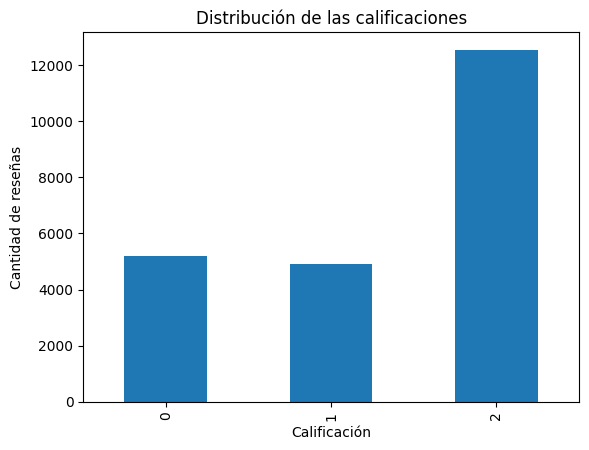

In [ ]:
df_reviews_mapped.Rating.value_counts().sort_index().plot(kind='bar', title='Distribución de las calificaciones')
plt.xlabel('Calificación')
plt.ylabel('Cantidad de reseñas')
plt.show()

Contar la cantidad de muestras por cada categoría

In [ ]:
counts = df_reviews_mapped['Rating'].value_counts()
counts

2    12540
0     5193
1     4908
Name: Rating, dtype: int64

Encontrar la categoría con el recuento mínimo

In [ ]:
min_count = min(counts)
min_count

4908

Hacer remuestreo para igualar el recuento mínimo de muestras para cada categoría


In [ ]:
df_balanced = pd.concat([df_reviews_mapped[df_reviews_mapped['Rating'] == rating].sample(min_count, replace=True) for rating in counts.index])
df_balanced['Rating'].value_counts()

2    4908
0    4908
1    4908
Name: Rating, dtype: int64

Tomar la columna de las review y almacenarlo todo en un vector numpy de reviews

In [ ]:
reviews = df_balanced['Review Text'].values

¿Cuantas reviews (rows) hay para evaluar?

In [ ]:
df_balanced.shape[0]

14724

Concatenar todas las reviews para armar el corpus

In [ ]:
corpus = ' '.join(reviews)
corpus[:1000]

'I bought this top as it is perfect for work under a blazer! the patten is pretty and eye catching, i love that it\'s 100% silk and has the tie in front so it\'s not too low for work. so chic and sophisticated! So, i really like this sweater, as you\'d expect for this price point, it\'s stylish in a very single way. so glad i read the review before mine to size down. the xs is great and i wouldn\'t want bigger. i love the length: how it goes long and cones in a little at the bottom, and the pockets are higher(i always need pockets for my phone). the stripes are well draped as the sweater transitions from shoulder to arm. the cuffs are fun, too. \r\nbottom line:  i\'m really glad this came on sale and i snatc Love the soft fabric and easy fit of this dress. i\'m pleased that it does give a hint of one\'s figure and doesn\'t just hang like a sack. i found the blue to be most flattering and was playing with styling at home and found that the wider retailer "tabby" leather belt gave it a w

¿Cuál es la longitud de ese corpus?

In [ ]:
len(corpus)

4600856

Utilizar "text_to_word_sequence" para separar las palabras en tokens

Recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase

In [ ]:
from keras.preprocessing.text import text_to_word_sequence

In [ ]:
tokenized_corpus = text_to_word_sequence(corpus)

Dar un vistazo a los primeros 20 tokens/palabras

In [ ]:
tokenized_corpus[:20]

['i',
 'bought',
 'this',
 'top',
 'as',
 'it',
 'is',
 'perfect',
 'for',
 'work',
 'under',
 'a',
 'blazer',
 'the',
 'patten',
 'is',
 'pretty',
 'and',
 'eye',
 'catching']

¿Cuántos tokens/palabras hay?

In [ ]:
len(tokenized_corpus)

901813

Alumno: Tokenizar las palabras con el Tokenizer de Keras

Definir una máxima cantidad de palabras a utilizar:

num_words --> the maximum number of words to keep, based on word frequency.

Only the most common num_words-1 words will be kept.

In [ ]:
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words

In [ ]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(reviews)

Obtener el diccionario de palabra (word) a índice # y observar la cantidad total del vocabulario

In [ ]:
word_index = tokenizer.word_index
print('Se encontraron %s tokens unicos.' % len(word_index))

Se encontraron 10743 tokens unicos.


Convertir las palabras/tokens a números

In [ ]:
sequences = tokenizer.texts_to_sequences(reviews)
print(sequences[:10])

[[2, 85, 7, 24, 31, 4, 6, 72, 13, 100, 268, 5, 858, 1, 6, 89, 3, 744, 1963, 2, 26, 20, 33, 852, 719, 3, 92, 1, 493, 9, 149, 16, 33, 19, 32, 288, 13, 100, 16, 859, 3, 1629], [16, 2, 52, 25, 7, 91, 31, 1411, 661, 13, 7, 146, 571, 33, 617, 9, 5, 22, 1630, 103, 16, 370, 2, 611, 1, 557, 412, 545, 8, 21, 79, 1, 96, 6, 41, 3, 2, 487, 228, 522, 2, 26, 1, 84, 171, 4, 445, 95, 3, 9, 5, 53, 44, 1, 173, 3, 1, 303, 28, 605, 2, 375, 205, 303, 13, 18, 1, 662, 28, 66, 1609, 31, 1, 91, 107, 467, 8, 359, 1, 1366, 28, 319, 32, 67, 173, 314, 35, 52, 370, 7, 367, 11, 155, 3, 2], [26, 1, 71, 40, 3, 312, 27, 14, 7, 17, 35, 860, 20, 4, 142, 318, 5, 14, 351, 3, 199, 36, 774, 25, 5, 748, 2, 230, 1, 168, 8, 30, 253, 61, 3, 12, 15, 770, 44, 672, 3, 230, 20, 1, 730, 115, 867, 414, 687, 4, 5, 815, 494, 51], [7, 6, 5, 76, 17, 1204, 14, 1434, 318, 4, 5, 41, 160, 1, 116, 3, 132, 28, 22, 61, 98, 1631, 4, 8, 30, 153, 1189, 1130, 422, 11, 236, 723, 39, 978, 13, 1879, 524, 22, 330, 15, 7], [2, 37, 402, 586, 917, 3, 99, 1,

Determinar cual es la oración más larga

In [ ]:
max_length = max(len(s) for s in sequences)
print('La oración más larga tiene %d tokens.' % max_length)

La oración más larga tiene 113 tokens.


Realizar padding de las sentencias al mismo tamaño
tomando de referencia la máxima sentencia

In [ ]:
from tensorflow.keras.utils import pad_sequences

In [ ]:
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [ ]:
padded_sequences[:10]

array([[   2,   85,    7, ...,    0,    0,    0],
       [  16,    2,   52, ...,    0,    0,    0],
       [  26,    1,   71, ...,    0,    0,    0],
       ...,
       [   2,   85,   62, ...,    0,    0,    0],
       [  26,    1, 1798, ...,    0,    0,    0],
       [  65, 1020, 1172, ...,    0,    0,    0]], dtype=int32)

Observar las dimensiones de la variable input

In [ ]:
padded_sequences.shape

(14724, 113)

Tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding

Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad

de clases que se deseen predecir (en este ejemplo son 3)

In [ ]:
y = to_categorical(df_balanced['Rating'], num_classes=3)
y.shape

(14724, 3)

In [ ]:
y[:10]

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

Dividir los datos en train y test

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(11043, 113) (3681, 113) (11043, 3) (3681, 3)


Determinar la dimensiones de entrada y salida

In [ ]:
print('La dimensión de entrada es %d' % X_train.shape[1])
print('La dimensión de salida es %d' % y_train.shape[1])

La dimensión de entrada es 113
La dimensión de salida es 3


### 2 - Entrenar el modelo con Embeddings + LSTM

Entrene su modelo con LSTM entrenando sus propios embeddings
o utilizando embeddings pre-entrenados.

In [ ]:
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout

Entrene su modelo con LSTM entrenando sus propios embeddings o utilizando embeddings pre-entrenados.

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_length))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 113, 100)          200000    
                                                                 
 lstm_4 (LSTM)               (None, 100)               80400     
                                                                 
 dense_4 (Dense)             (None, 3)                 303       
                                                                 
Total params: 280703 (1.07 MB)
Trainable params: 280703 (1.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Entrenar el modelo

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10
173/173 [==============================] - 101s 565ms/step - loss: 1.0995 - accuracy: 0.3303 - val_loss: 1.0990 - val_accuracy: 0.3325
Epoch 2/10
173/173 [==============================] - 70s 404ms/step - loss: 1.0984 - accuracy: 0.3456 - val_loss: 1.0967 - val_accuracy: 0.3665
Epoch 3/10
173/173 [==============================] - 70s 406ms/step - loss: 1.0491 - accuracy: 0.4484 - val_loss: 1.0685 - val_accuracy: 0.4129
Epoch 4/10
173/173 [==============================] - 67s 385ms/step - loss: 1.0621 - accuracy: 0.4072 - val_loss: 1.0631 - val_accuracy: 0.3898
Epoch 5/10
173/173 [==============================] - 69s 398ms/step - loss: 1.0736 - accuracy: 0.4030 - val_loss: 1.1256 - val_accuracy: 0.3374
Epoch 6/10
173/173 [==============================] - 66s 383ms/step - loss: 1.1029 - accuracy: 0.3344 - val_loss: 1.0993 - val_accuracy: 0.3301
Epoch 7/10
173/173 [==============================] - 66s 380ms/step - loss: 1.1006 - accuracy: 0.3359 - val_loss: 1.1026 - val_a

Evaluar el modelo

In [ ]:
print('Entrenamiento:')
model.evaluate(X_train, y_train)
print('Test:')
model.evaluate(X_test, y_test)

Entrenamiento:
346/346 [==============================] - 13s 37ms/step - loss: 1.0995 - accuracy: 0.3336
Test:
116/116 [==============================] - 4s 34ms/step - loss: 1.0998 - accuracy: 0.3325


[1.099824070930481, 0.3325183391571045]

Graficar la pérdida y precisión

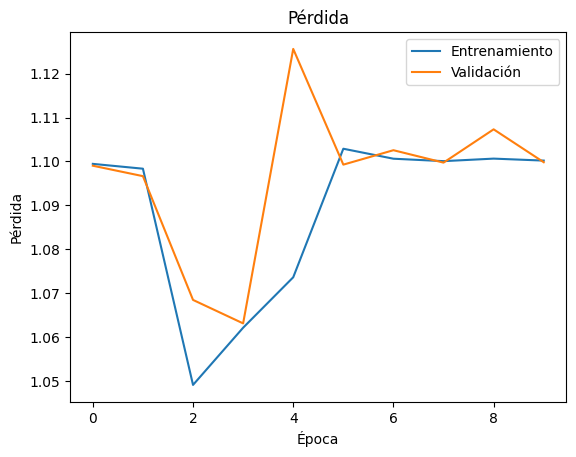

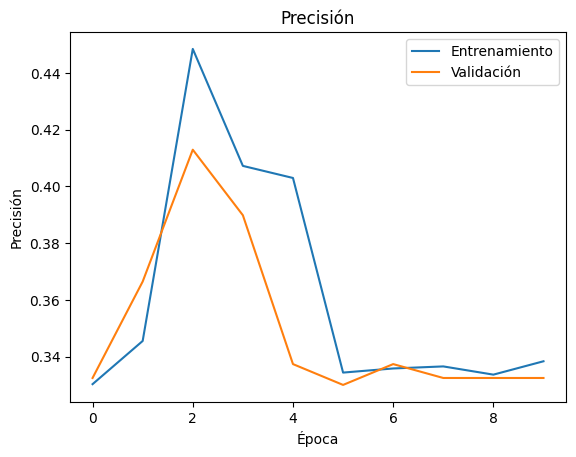

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend(['Entrenamiento', 'Validación'])
plt.show()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

# Pruebo otro modelo con embeddings

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
# Descargar los archivos GloVe embeddings en un notebook de Colab
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2023-12-17 02:29:04--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-12-17 02:29:04--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-12-17 02:29:04--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
MAX_WORDS = num_words
MAX_SEQUENCE_LENGTH = max_length
EMBEDDING_DIM = 100

Cargar embeddings pre-entrenados (por ejemplo, GloVe embeddings)

Descargar GloVe embeddings: https://nlp.stanford.edu/projects/glove/

In [ ]:
embedding_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

Crear la matriz de embeddings

In [ ]:
word_index = tokenizer.word_index
num_words = min(MAX_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_WORDS:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
model = Sequential()
model.add(Embedding(num_words, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix], trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Entrenar el modelo

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=64)

Epoch 1/5
173/173 [==============================] - 63s 340ms/step - loss: 0.6403 - accuracy: 0.3478 - val_loss: 0.6361 - val_accuracy: 0.3502
Epoch 2/5
173/173 [==============================] - 67s 386ms/step - loss: 0.6359 - accuracy: 0.3482 - val_loss: 0.6370 - val_accuracy: 0.3328
Epoch 3/5
173/173 [==============================] - 60s 344ms/step - loss: 0.6385 - accuracy: 0.3460 - val_loss: 0.6370 - val_accuracy: 0.3301
Epoch 4/5
173/173 [==============================] - 62s 357ms/step - loss: 0.6363 - accuracy: 0.3465 - val_loss: 0.6355 - val_accuracy: 0.3581
Epoch 5/5
173/173 [==============================] - 60s 345ms/step - loss: 0.6358 - accuracy: 0.3497 - val_loss: 0.6361 - val_accuracy: 0.3341


Evaluar el modelo

In [ ]:
print('Entrenamiento:')
model.evaluate(X_train, y_train)
print('Test:')
model.evaluate(X_test, y_test)

Entrenamiento:
346/346 [==============================] - 13s 36ms/step - loss: 0.6357 - accuracy: 0.3399
Test:
116/116 [==============================] - 4s 34ms/step - loss: 0.6361 - accuracy: 0.3341


[0.6360806822776794, 0.3341483175754547]

Graficar la pérdida y precisión

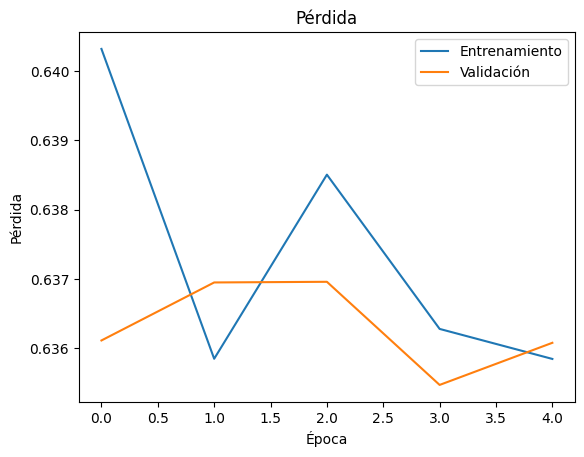

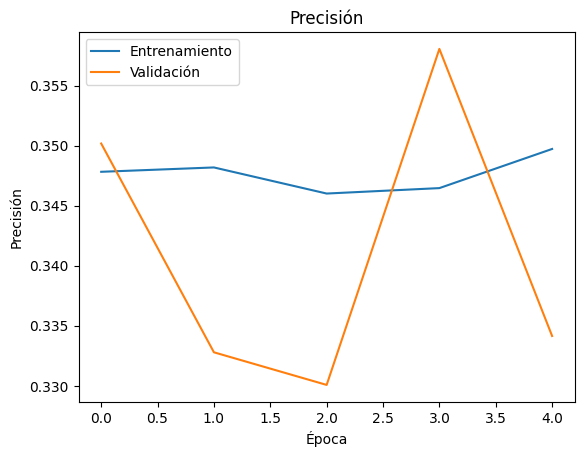

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend(['Entrenamiento', 'Validación'])
plt.show()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

# Conclusión
El modelo con embeddings pre-entrenados terminó con un accuracy muy similar al modelo sin embeddings. Para mejorar la performance de ambos modelos se pordían modfificar los hiperparametros y cambiar la cantidad de tokens maximo, el numero de batch, la camtida de epocas o la máxima longitud tomada.